# Multimodal RAG with ColNomic Embed Multimodal

ColNomic Embed Multimodal is a late interaction embedding model that processes both text and images. It can directly process the visual content in PDFs without requiring preprocessing steps like OCR or image captioning. 

In this notebook, we demonstrate how to use it with `byaldi` and `openai` to build multimodal RAG that can answer questions using information from PDFs containing both text and visual elements.

## Preview PDF

We are going to use a pdf of data from from the US Department of Labor you can download [here](https://assets.nomicatlas.com/department-of-labor-data.pdf).

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


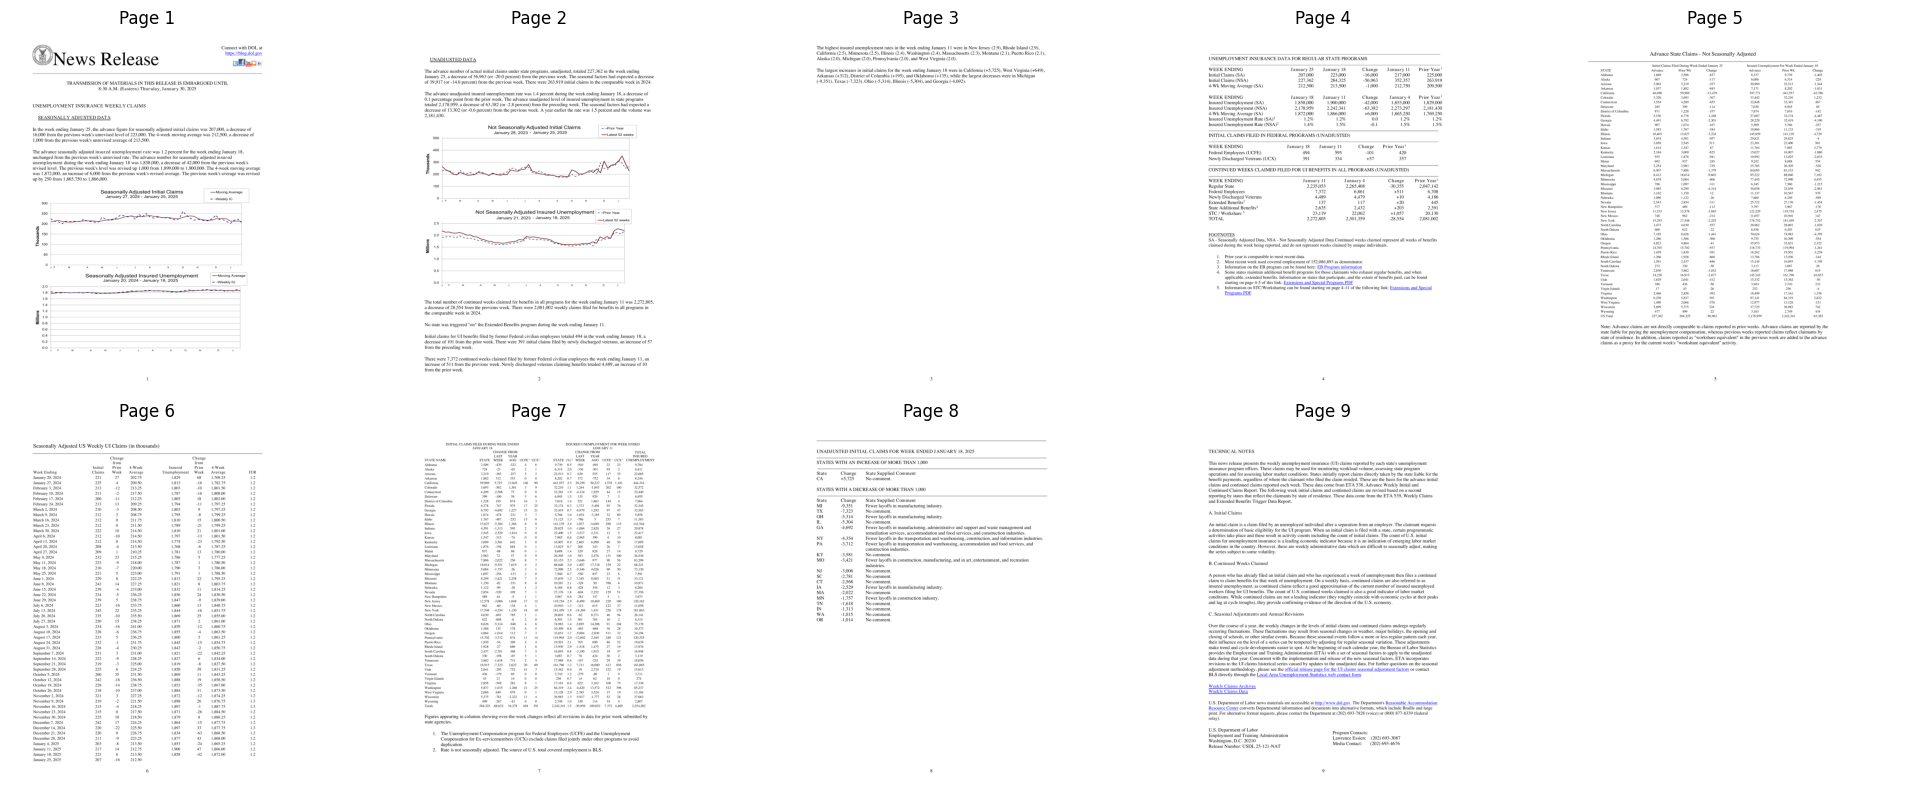

In [40]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

def display_pdf_images(images_list):
    """Display all images in the provided list as subplots with 5 images per row."""
    num_images = len(images_list)
    num_rows = num_images // 5 + (1 if num_images % 5 > 0 else 0)    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    if num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    else:
        axes = axes.flatten()
    for i, img in enumerate(images_list):
        if i < len(axes):
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Page {i+1}")
            ax.axis('off')     
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

pdf_images = convert_from_path("department-of-labor-data.pdf")

display_pdf_images(pdf_images)

## Create RAG Index

We create a RAG index over the PDF using the [`byaldi`](https://github.com/AnswerDotAI/byaldi) library with `colnomic-embed-multimodal` as our retriever.

In [2]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained(
    "nomic-ai/colnomic-embed-multimodal-3b",
    device="cpu"
)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of ColQwen2_5 were not initialized from the model checkpoint at Qwen/Qwen2.5-VL-3B-Instruct and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/240M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/7.41k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: max_num_visual_tokens. 


In [6]:
RAG.index(
    input_path="department-of-labor-data.pdf",
    index_name="image_index", 
    store_collection_with_index=False,
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: 'department-of-labor-data.pdf'}

## Setup Retrieval and Image Querying

The `query_image` function uses a vision-language model (VLM) to ask a question of an image, which we will use to answer the user query.

In [77]:
from openai import OpenAI
import base64
from io import BytesIO
import textwrap

client = OpenAI()

def query_image(query: str, image: Image) -> str:
    """Queries VLM with a text and image input"""
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    base64_image = base64.b64encode(buffered.getvalue()).decode("utf-8")
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "developer",
                "content": "You are an expert professional PDF analyst who gives rigorous in-depth answers."
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": query},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                ],
            }
        ],
        max_tokens=1000,
    )
    return completion.choices[0].message.content

def plot_rag_result(query: str, answer: str, image: Image) -> None:
    """Plots user query, retrieved source doc as image, and VLM answer"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 1]})
    fig.suptitle(f"Query: {query}", fontsize=16, fontweight='bold', y=0.98)
    ax1.imshow(image)
    ax1.set_title("Source Document\nretrieved by ColNomic Embed Multimodal", fontsize=14, fontweight='bold')
    ax1.axis('off')
    ax2.axis('off')
    wrapped_answer = '\n'.join(['\n'.join(textwrap.wrap(line, width=50)) for line in answer.split('\n')])
    ax2.text(0.02, 0.97, wrapped_answer, transform=ax2.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2C3E50', linewidth=2, pad=1.0))
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()

In [56]:
query = "Did any states show a decrease in unemployment claims?"
rag_results = RAG.search(query, k=1)
image = pdf_images[rag_results[0]["page_num"] - 1]
answer = query_image(query, image)

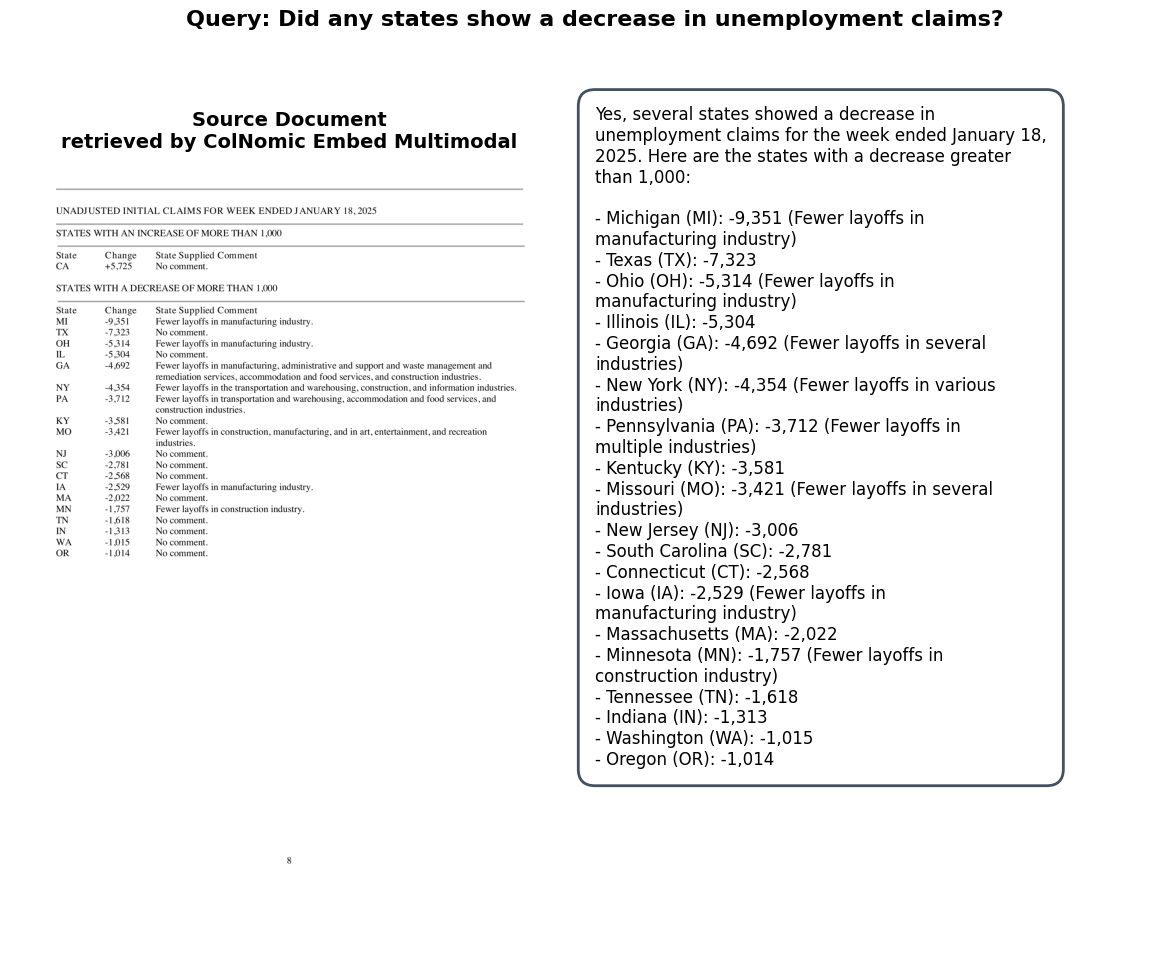

In [76]:
plot_rag_result(query, answer, image)